Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular,Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
import matplotlib.pyplot as plt

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

In [2]:
def decorrelate(num_epochs, data, model, lr=1e-2):

    # covariance matrix before training
    X = model.forward(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    D = np.zeros(num_epochs)
    V = np.zeros(num_epochs)
    for i in range(num_epochs):
        y = model.forward(data)
        D[i], V[i] = model.update()
        model.R -= lr * model.R.grad
        print(f'iteration {i}\ttotal loss: {D[i] + V[i]:.3f}')

    # covariance matrix after training
    X = model.forward(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return D, V, A1, A2

We start by showing effective decorrelation of correlated input

iteration 0	total loss: 0.146
iteration 1	total loss: 0.144
iteration 2	total loss: 0.143
iteration 3	total loss: 0.142
iteration 4	total loss: 0.141
iteration 5	total loss: 0.140
iteration 6	total loss: 0.139
iteration 7	total loss: 0.138
iteration 8	total loss: 0.137
iteration 9	total loss: 0.136
iteration 10	total loss: 0.135
iteration 11	total loss: 0.134
iteration 12	total loss: 0.133
iteration 13	total loss: 0.132
iteration 14	total loss: 0.131
iteration 15	total loss: 0.130
iteration 16	total loss: 0.129
iteration 17	total loss: 0.128
iteration 18	total loss: 0.127
iteration 19	total loss: 0.126
iteration 20	total loss: 0.125
iteration 21	total loss: 0.124
iteration 22	total loss: 0.123
iteration 23	total loss: 0.123
iteration 24	total loss: 0.122
iteration 25	total loss: 0.121
iteration 26	total loss: 0.120
iteration 27	total loss: 0.119
iteration 28	total loss: 0.119
iteration 29	total loss: 0.118
iteration 30	total loss: 0.117
iteration 31	total loss: 0.116
iteration 32	total

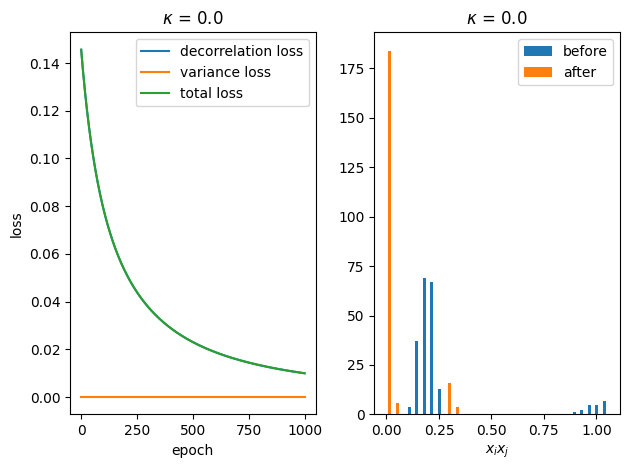

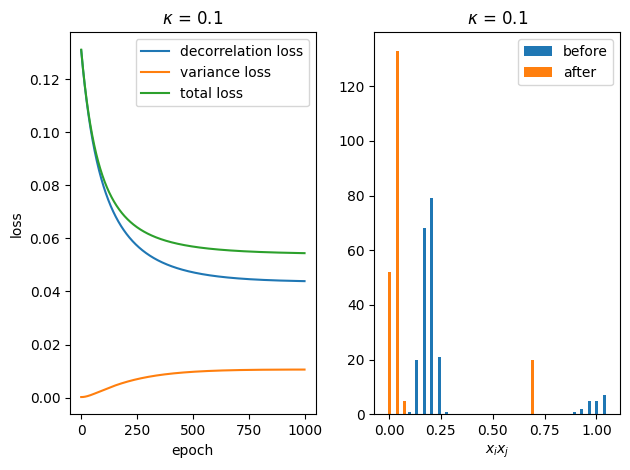

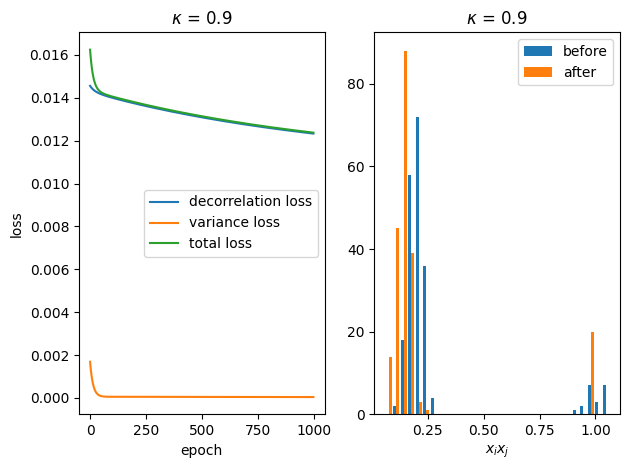

In [3]:
num_samples=1000
num_features=20
num_epochs=1000
kappas = [0.0, 0.1, 0.9]
lr=1e-1 # 4 * lr / num_features * (num_features-1) relative to original code...

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

for kappa in kappas:

    # create a decorrelator
    model = Decorrelation(size=num_features, kappa=kappa)

    D, V, A1, A2 = decorrelate(num_epochs, data, model, lr=lr) 

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(D, label='decorrelation loss')
    plt.plot(V, label='variance loss')
    plt.plot(D+V, label='total loss')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f'$\kappa$ = {kappa}')
    plt.subplot(1,2,2)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    plt.legend()
    plt.xlabel('$x_i x_j$')
    plt.title(f'$\kappa$ = {kappa}')
    plt.legend();
    plt.tight_layout()

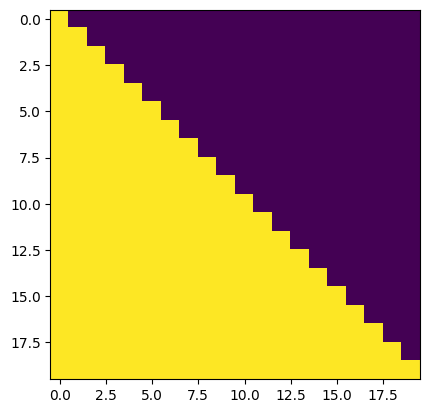

In [4]:
plt.imshow(model.R.detach().numpy() != 0);

Decorrelation of correlated input using DecorConv2d

In [12]:
def decorrelate(num_epochs, data, model, lr=1e-2):

    # PATCHES INSTEAD OF FORWARD
    # NOTE: WE CAN SEPARATE OUT PATH DECORRELATION AND USE THAT FOR THE COMBINED APPROACH...
    X = model.patches(data[1:3]) # 1:3 OTHERWISE WAY TOO LARGE
    A1 = (X.T @ X) / len(X)
    # A1 = None

    # train decorrelator
    D = np.zeros(num_epochs)
    V = np.zeros(num_epochs)
    for i in range(num_epochs):
        y = model.forward(data)
        D[i], V[i] = model.update()
        model.R -= lr * model.R.grad
        print(f'iteration {i}\ttotal loss: {D[i] + V[i]:.3f}')

    # covariance matrix after training
    X = model.patches(data[1:3])
    A2 = (X.T @ X) / len(X)
    # A2 = None

    return D, V, A1, A2

iteration 0	total loss: 0.874
iteration 1	total loss: 0.363
iteration 2	total loss: 0.174
iteration 3	total loss: 0.119
iteration 4	total loss: 0.064
iteration 5	total loss: 0.059
iteration 6	total loss: 0.043
iteration 7	total loss: 0.035
iteration 8	total loss: 0.029
iteration 9	total loss: 0.027
iteration 10	total loss: 0.021
iteration 11	total loss: 0.020
iteration 12	total loss: 0.018
iteration 13	total loss: 0.020
iteration 14	total loss: 0.012
iteration 15	total loss: 0.010
iteration 16	total loss: 0.010
iteration 17	total loss: 0.009
iteration 18	total loss: 0.009
iteration 19	total loss: 0.008
iteration 0	total loss: 0.787
iteration 1	total loss: 0.373
iteration 2	total loss: 0.213
iteration 3	total loss: 0.171
iteration 4	total loss: 0.121
iteration 5	total loss: 0.120
iteration 6	total loss: 0.105
iteration 7	total loss: 0.098
iteration 8	total loss: 0.093
iteration 9	total loss: 0.092
iteration 10	total loss: 0.084
iteration 11	total loss: 0.083
iteration 12	total loss: 0.0

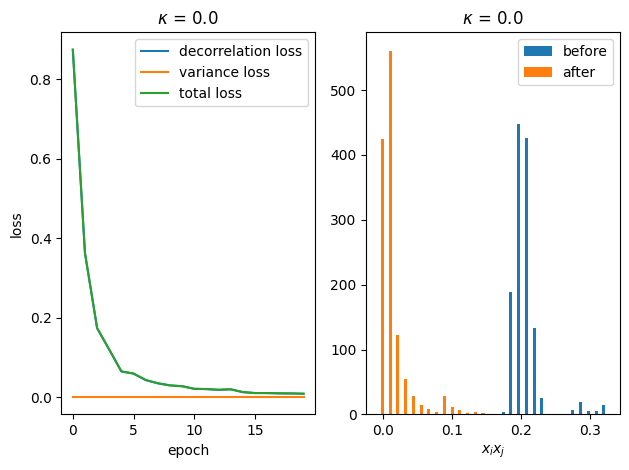

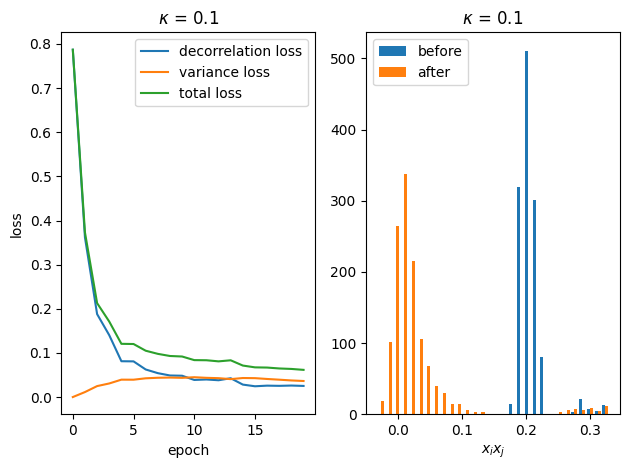

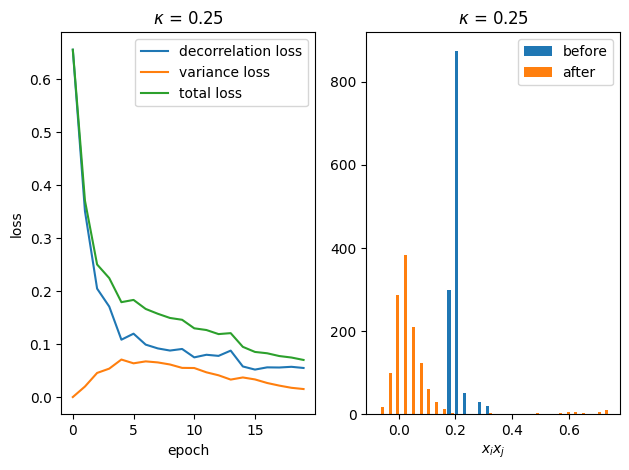

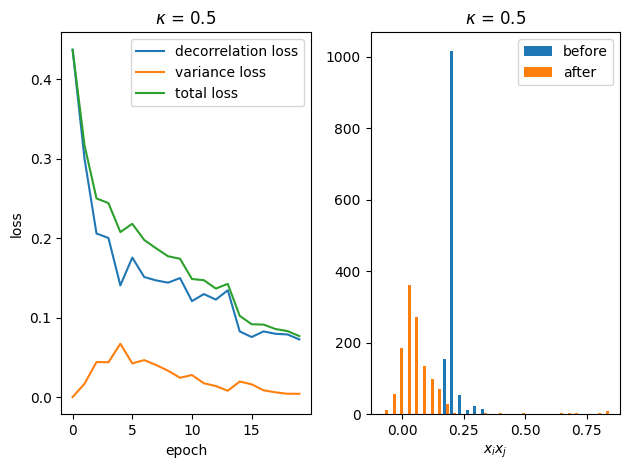

In [16]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=20
width=20
kernel_size=(5,5)
num_samples=1000
num_epochs=20
kappas = [0.0, 0.1, 0.25, 0.5]
seed = 42
num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

# ensure that we are at the same scale of the orig_lr
orig_lr=1e-2
lr = orig_lr * (size *  (size-1)) / 4

# gaat er iets mis met gradient updaten? Nee want dat zit hier niet in (no BP update performed; check daar wel clone etc)

for kappa in kappas:

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

    d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
    data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width)

    # create a convolutional decorrelator
    model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, kappa=kappa)

    D, V, A1, A2 = decorrelate(num_epochs, data, model, lr=lr) 

    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(D, label='decorrelation loss')
    plt.plot(V, label='variance loss')
    plt.plot(D+V, label='total loss')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f'$\kappa$ = {kappa}')
    plt.subplot(1,2,2)
    plt.hist([lower_triangular(A1, offset=0), lower_triangular(A2, offset=0)], bins=30, label=['before', 'after'])
    plt.legend()
    plt.xlabel('$x_i x_j$')
    plt.title(f'$\kappa$ = {kappa}')
    plt.legend();
    plt.tight_layout()

In [ ]:
# orig_lr=1e-2
# #orig_lr  = 4 * lr / (num_features *  (num_features-1))
# lr = orig_lr * (num_features *  (num_features-1)) / 4
# eff_lr = 4 * lr / (num_features *  (num_features-1))
# print(f'original lr: {orig_lr}; lr: {lr}; effective lr: {eff_lr}')

In [ ]:
# WHEN IT WORKS WE CAN START TO COMBINE WITH A PATCHWISE MODEL

To do:
- experiment can be used if current approach works. Do we have any guarantee of decorrelated input if average over patches? and if we take only center pixel? We can check by extracting the patches for the created output again and compute covariances
- reimplement code sander as starting point also for comparison